# Comparison of various Classification algorithms

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, f1_score
)

## Custom functions to evaluate models

In [2]:
# Define all the funcs to later evaluate models
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.matshow(cm, cmap="coolwarm", alpha=0.7)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=cm[i, j], ha='center', va='center')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


def plot_precision_recall(y_true, y_probs, model_name="Model"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1 = f1_score(y_true, (y_probs >= 0.5).astype(int))
    plt.figure()
    plt.plot(recall, precision,
             label=f"Precision-Recall Curve (F1 = {f1:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_probs, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()

# Malicious
dfm = pd.read_csv("test1.csv")
# Benign
dfb = pd.read_csv("testm.csv")

df = pd.concat([dfm, dfb], ignore_index=True)
df.head(5)

,Version,Error Correction Level,Number of Blocks,Expected number of data codewords,Actual number of data codewords,Number of empty bytes,Number of EC Codewords,Errors corrected,Modified
0,3,M,1,44,44,0,26,0,0
1,2,H,1,16,16,0,28,0,0
2,5,Q,4,62,62,0,18,0,0
3,6,Q,4,76,76,0,24,0,0
4,6,M,4,108,108,0,16,0,0


## Dataframe preparation
This is just demonstration, this should be done while generating the csv, and based of the origin of the qr code (i.e. (malicious dataset) -> modified)

In [3]:
df['Modified'] = df['Number of empty bytes'].apply(lambda x: 1 if x > 0 else 0)
df['EC Level'] = df['Error Correction Level'].map(
    {'L': 1, 'M': 2, 'Q': 3, 'H': 4}).astype(int)

df.to_csv("test.csv", sep='\t')
df.head(10)

,Version,Error Correction Level,Number of Blocks,Expected number of data codewords,Actual number of data codewords,Number of empty bytes,Number of EC Codewords,Errors corrected,Modified,EC Level
0,3,M,1,44,44,0,26,0,0,2
1,2,H,1,16,16,0,28,0,0,4
2,5,Q,4,62,62,0,18,0,0,3
3,6,Q,4,76,76,0,24,0,0,3
4,6,M,4,108,108,0,16,0,0,2
5,8,Q,6,110,110,0,22,0,0,3
6,4,M,2,64,64,0,18,0,0,2
7,10,Q,8,154,153,1,24,0,1,3
8,10,M,5,216,214,2,26,0,1,2
9,9,Q,8,132,132,0,20,0,0,3


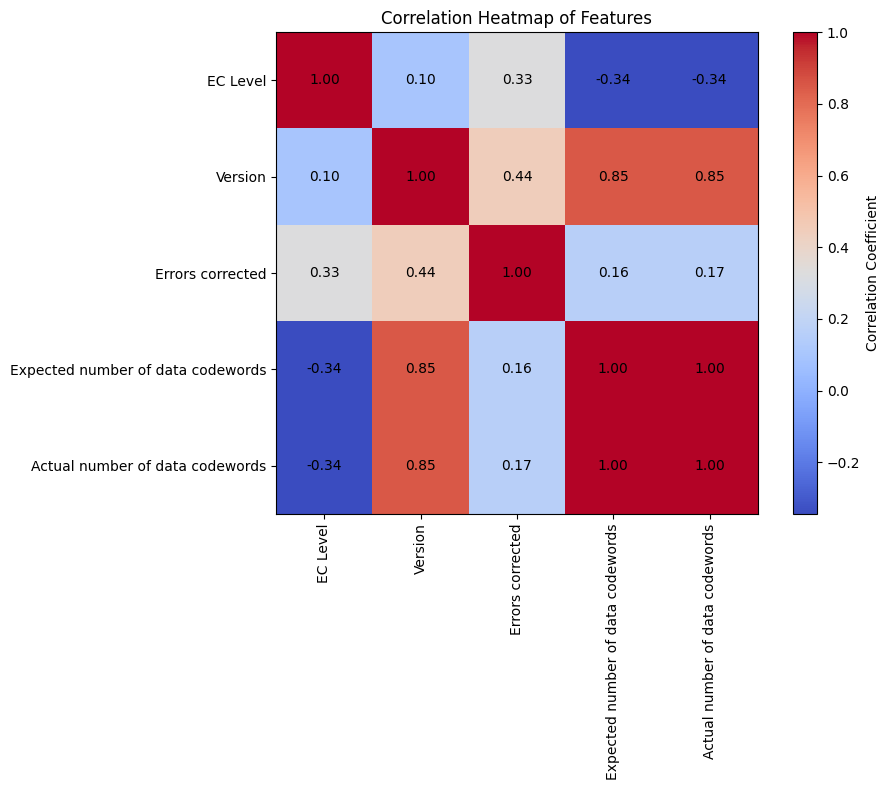

In [4]:
#train_X = df[['Version', 'EC Level', 'Number of empty bytes', 'Expected number of data codewords',
              #'Actual number of data codewords',
              #'Errors corrected']]
train_X = df[['EC Level', 'Version',
              'Errors corrected', 'Expected number of data codewords', 'Actual number of data codewords']]
# this is to be determined later whether or not we limit ourselves to just
# these features or not
correlation_matrix = train_X.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label='Correlation Coefficient')

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", 
                 ha="center", va="center", color="black")


plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

In [5]:
train_y = df['Modified']
train_y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    0
Name: Modified, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_X,
                                                    train_y, test_size=0.3,
                                                    random_state=42)

X_train.head(10)

print("Test set size: " + str(X_test.size))
print("Train set size: " + str(X_train.size))

Test set size: 140770
Train set size: 328460


## Random Forest

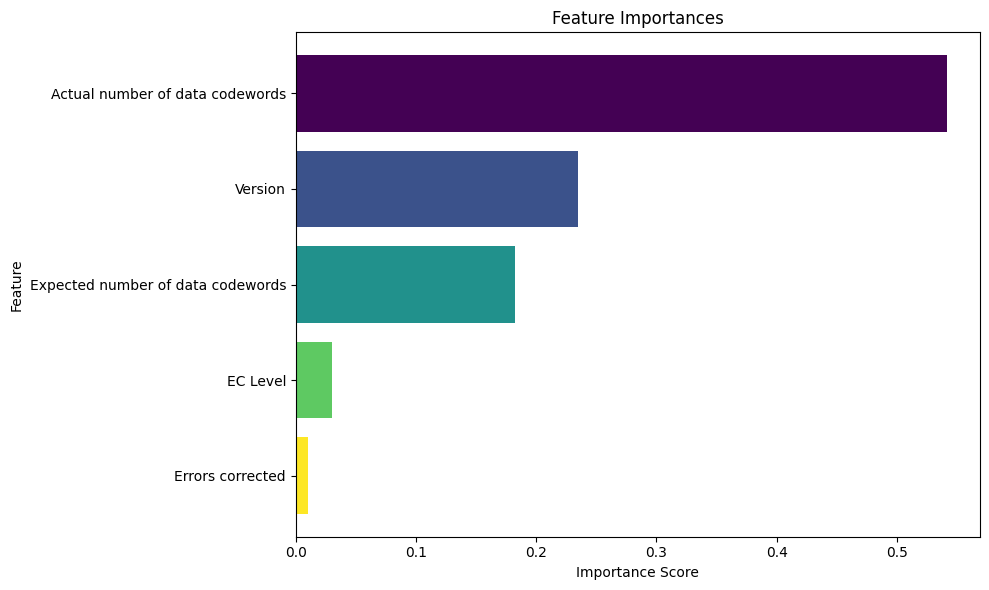

<Figure size 640x480 with 0 Axes>

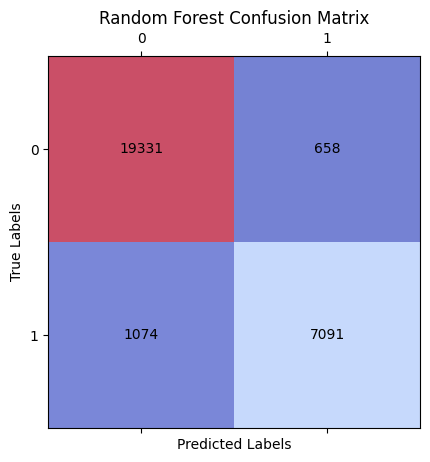

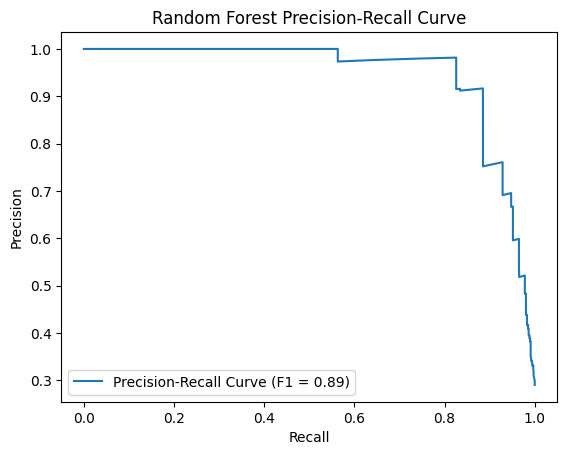

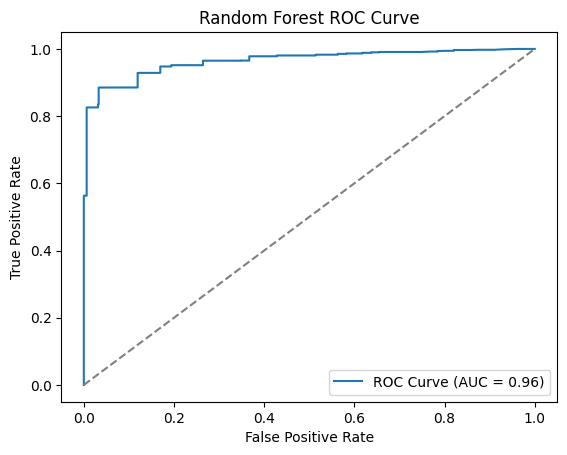

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     19989
           1       0.92      0.87      0.89      8165

    accuracy                           0.94     28154
   macro avg       0.93      0.92      0.92     28154
weighted avg       0.94      0.94      0.94     28154

CPU times: user 5.03 s, sys: 986 ms, total: 6.01 s
Wall time: 4.88 s


In [7]:
%%time
rf = RFC(random_state=42, criterion="entropy", n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

# Assume rf is the trained Random Forest model and X_full is the feature dataset
importances_full = rf.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances_full)[::-1]  # Sort in descending order
sorted_importances = importances_full[indices]
sorted_features = feature_names[indices]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_importances))))

# Add feature labels to the y-axis
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important features at the top

# Add labels and title
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

# Show the plot
plt.tight_layout()
plt.show()

plot_confusion_matrix(y_test, rf_pred, title="Random Forest Confusion Matrix")
plot_precision_recall(y_test, rf_probs, model_name="Random Forest")
plot_roc_curve(y_test, rf_probs, model_name="Random Forest")
print(classification_report(y_test, rf_pred))

## XGBoost

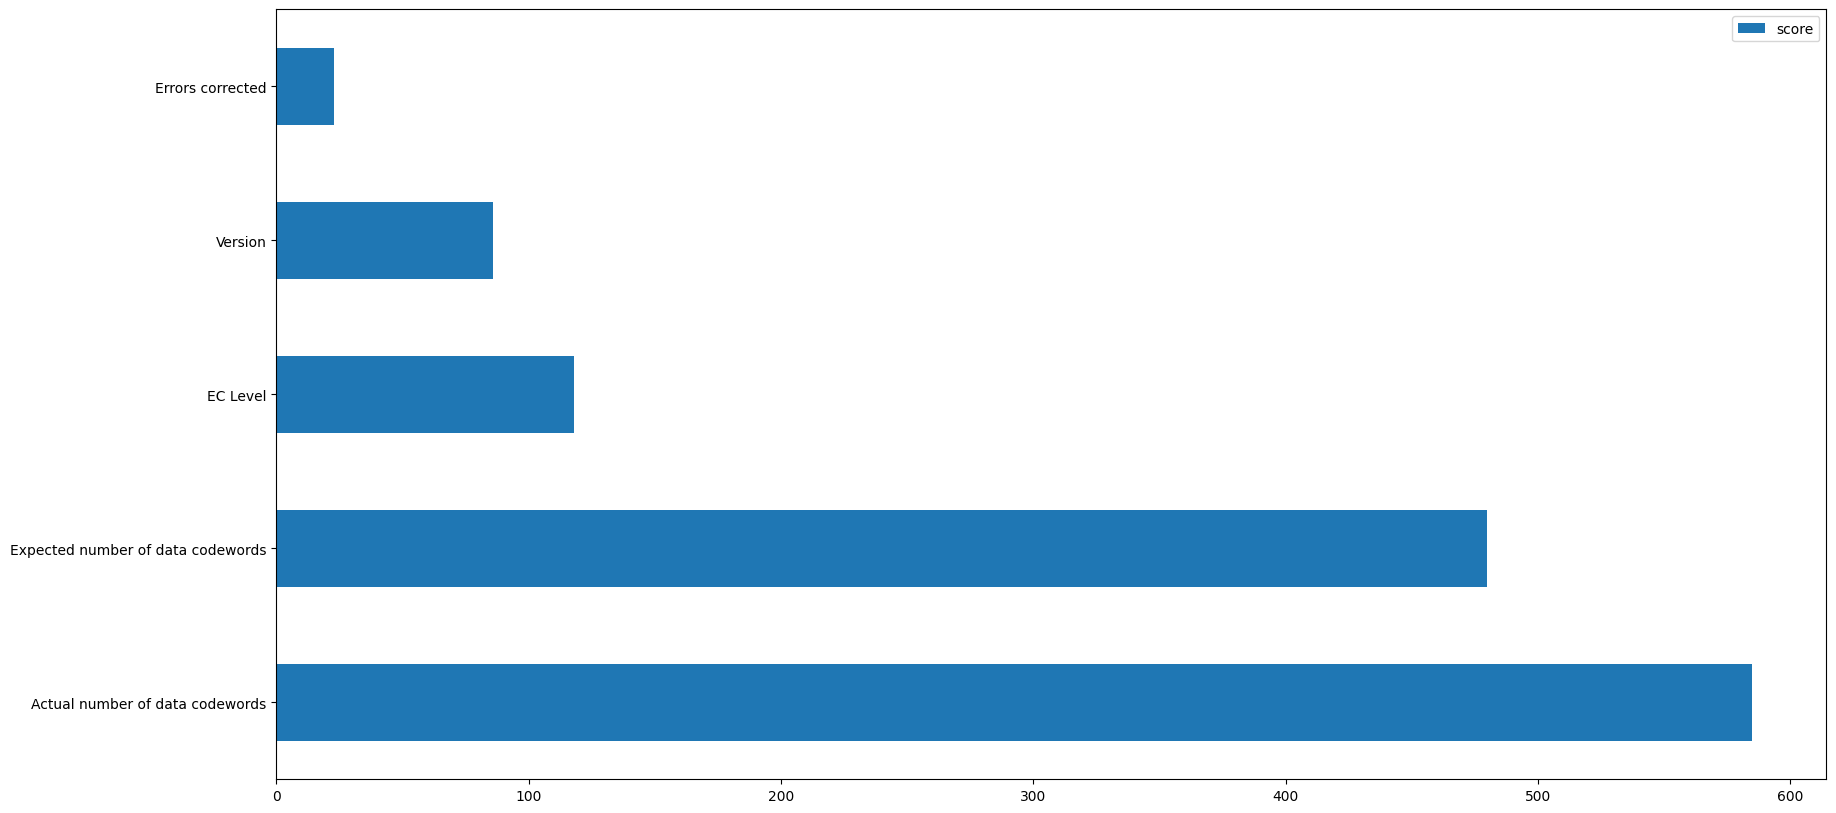

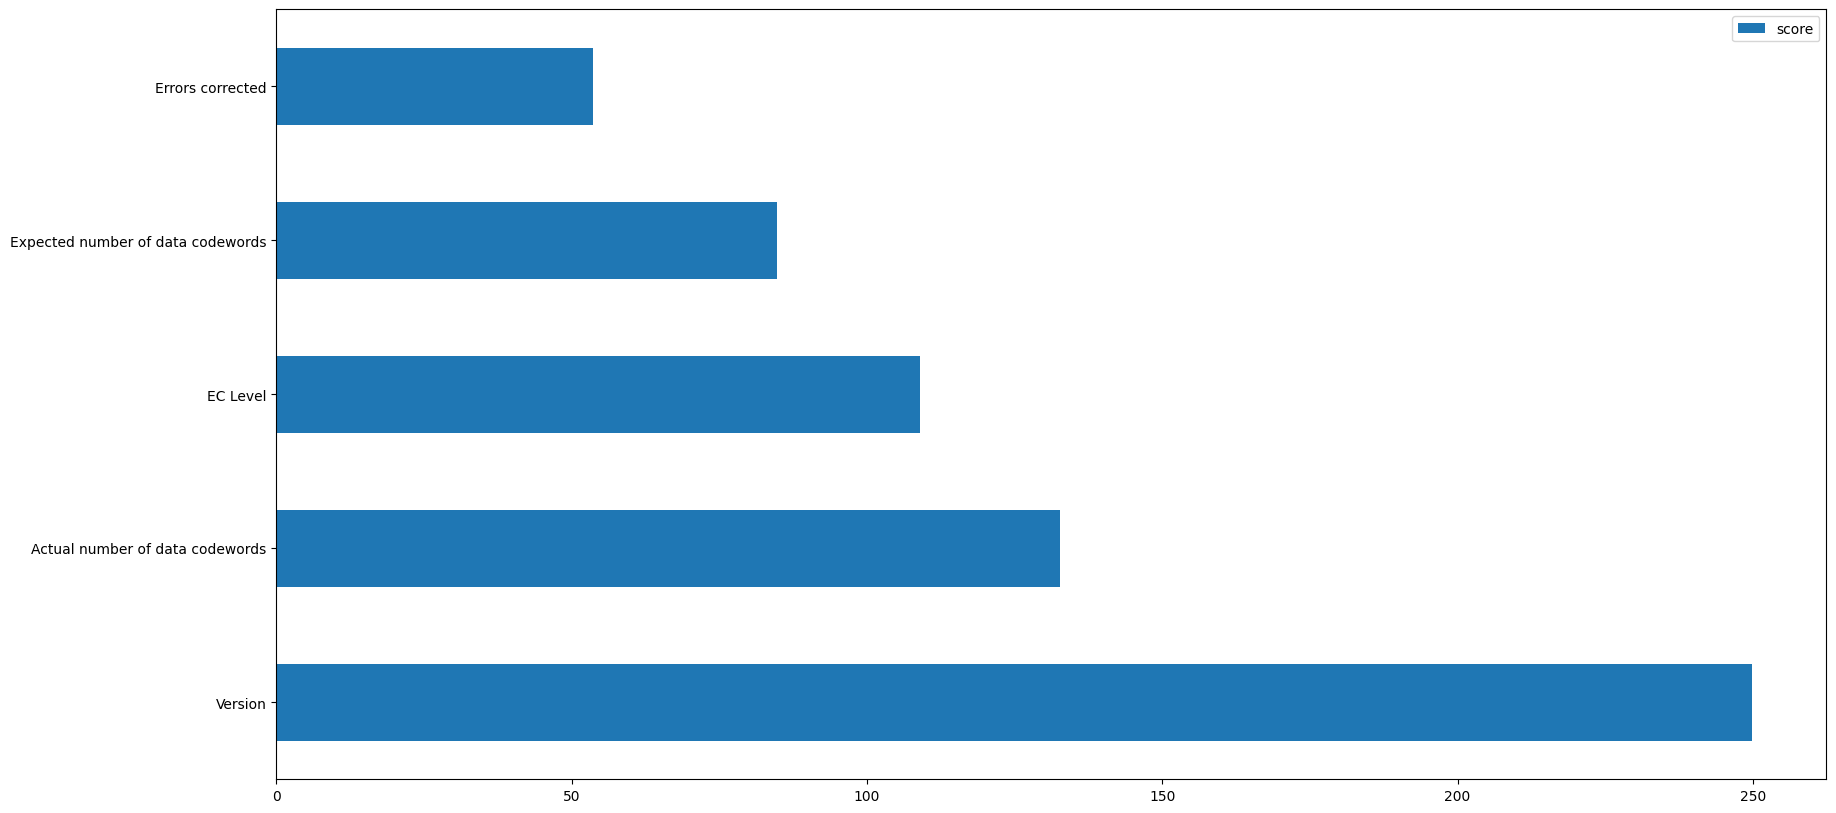

<Figure size 640x480 with 0 Axes>

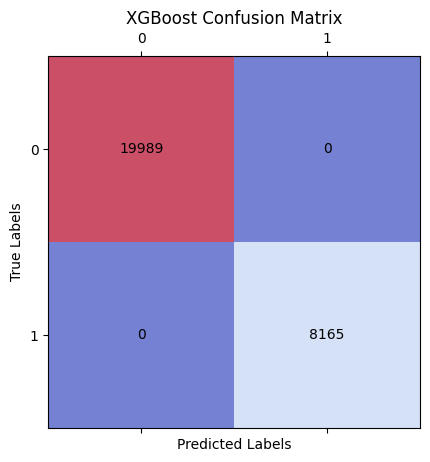

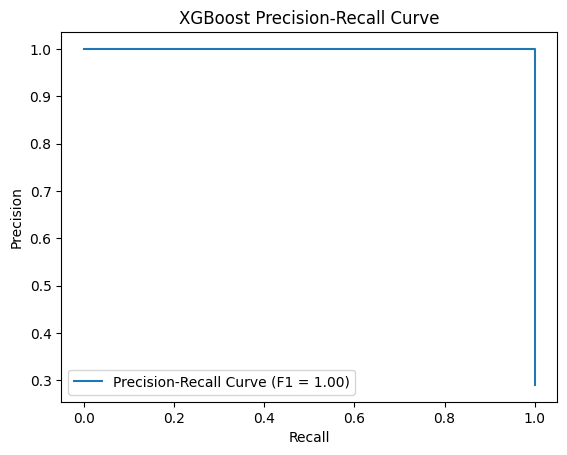

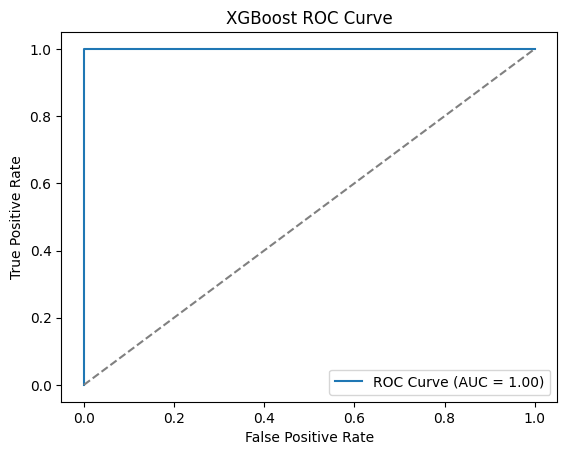

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19989
           1       1.00      1.00      1.00      8165

    accuracy                           1.00     28154
   macro avg       1.00      1.00      1.00     28154
weighted avg       1.00      1.00      1.00     28154

CPU times: user 1h 31min 3s, sys: 9.84 s, total: 1h 31min 13s
Wall time: 2min 1s


In [8]:
%%time
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

feature_important1 = xgb.get_booster().get_score(importance_type='gain')
keys1 = list(feature_important1.keys())
values1 = list(feature_important1.values())

data1 = pd.DataFrame(data=values1, index=keys1, columns=["score"]).sort_values(by = "score", ascending=False)
data1.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

plot_confusion_matrix(y_test, xgb_pred, title="XGBoost Confusion Matrix")
plot_precision_recall(y_test, xgb_probs, model_name="XGBoost")
plot_roc_curve(y_test, xgb_probs, model_name="XGBoost")
print(classification_report(y_test, xgb_pred))

## Support Vector Classifier

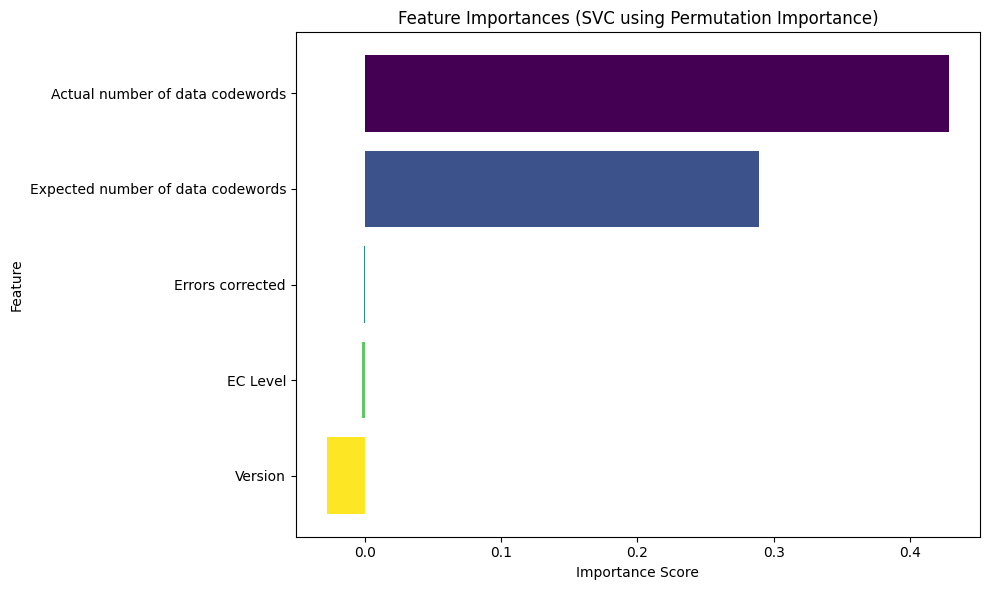

<Figure size 640x480 with 0 Axes>

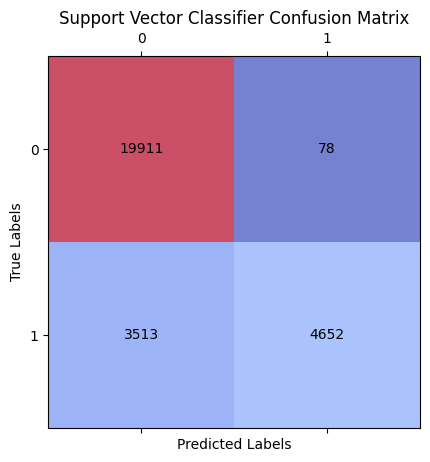

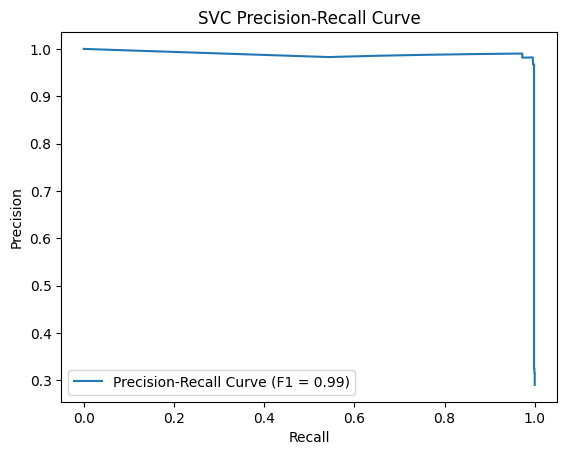

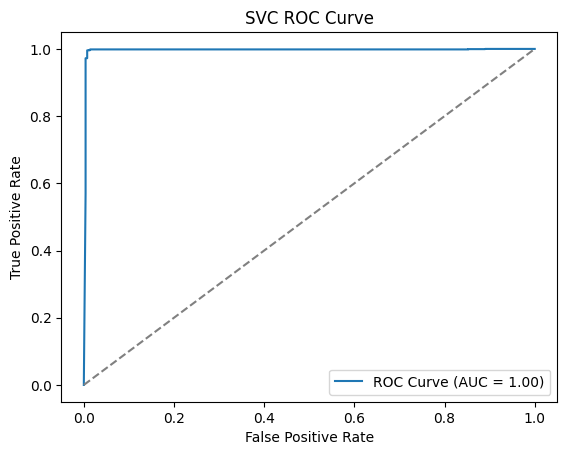

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     19989
           1       0.98      0.57      0.72      8165

    accuracy                           0.87     28154
   macro avg       0.92      0.78      0.82     28154
weighted avg       0.89      0.87      0.86     28154

CPU times: user 53min 35s, sys: 741 ms, total: 53min 36s
Wall time: 53min 34s


In [11]:
%%time
svc = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)
svc_probs = svc.predict_proba(X_test)[:, 1]

svc_imp = permutation_importance(svc, X_test, y_test, n_repeats=10, random_state=42)
svc_impts = svc_imp.importances_mean

feature_names = X_train.columns

indices = np.argsort(svc_impts)[::-1]
sorted_importances = svc_impts[indices]
sorted_features = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_importances))))
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()
plt.title("Feature Importances (SVC using Permutation Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plot_confusion_matrix(y_test, svc_pred, title="Support Vector Classifier Confusion Matrix")
plot_precision_recall(y_test, svc_probs, model_name="SVC")
plot_roc_curve(y_test, svc_probs, model_name="SVC")
print(classification_report(y_test, svc_pred))

## Dump model(s)

In [ ]:
#rf.predict
dump(rf, "model.xz")